# Predicting King County Housing Prices

This project takes the data for houses in King County Washington in order to predict home prices based upon various features. We use linear regression modeling on various features in order to predict these prices.

BUSINESS PROBLEM
what zipcodes have the lowest prices, predicted prices of homes in the area, and any relevant differences between the real prices and our model's predicted price?

## Import Libraries and Data

In [4]:
# data manipulation
import pandas as pd
import numpy as np
import json

# statistical analysis and modeling 
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
import scipy.stats as stats

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import folium
%matplotlib inline

In [7]:
# Import the data
df = pd.read_csv("C:/Users/ADMIN/Downloads/kc_house_data.csv")
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12-09-2014,538000,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12-09-2014,604000,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000,3,2.50,1530,1131,3.0,0.0,0.0,...,8,1530,0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000,4,2.50,2310,5813,2.0,0.0,0.0,...,8,2310,0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101,2,0.75,1020,1350,2.0,0.0,0.0,...,7,1020,0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000,3,2.50,1600,2388,2.0,NaN,0.0,...,8,1600,0,2004,0.0,98027,47.5345,-122.069,1410,1287


## Data Cleaning 

Replace categorical values with numeric data types. 

In [9]:
# assign new variables to relevent columns

df.waterfront.replace({'NO': 0, 'YES': 1}, inplace=True)
df.view.replace({'NONE': 0, 'FAIR': 1, 'AVERAGE': 2, 'GOOD': 3, 'EXCELLENT': 4}, inplace=True)
df.condition.replace({'Poor': 0, 'Fair': 1, 'Average': 2, 'Good': 3, 'Very Good': 4}, inplace=True)
df.grade.replace({'3 Poor': 0, '4 Low': 1, '5 Fair': 2, '6 Low Average': 3, '7 Average': 4, '8 Good': 5, 
                  '9 Better': 6, '10 Very Good': 7, '11 Excellent': 8, '12 Luxury': 9, '13 Mansion': 10}, 
                 inplace=True)
df.sqft_basement.replace('?', np.NaN, inplace=True)
df.sqft_basement = df.sqft_basement.astype(float)


## Data Analysis

Create a heat map to show the correlation of every column to decide which features are usuful in a model. 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8732\919053055.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = df.corr()


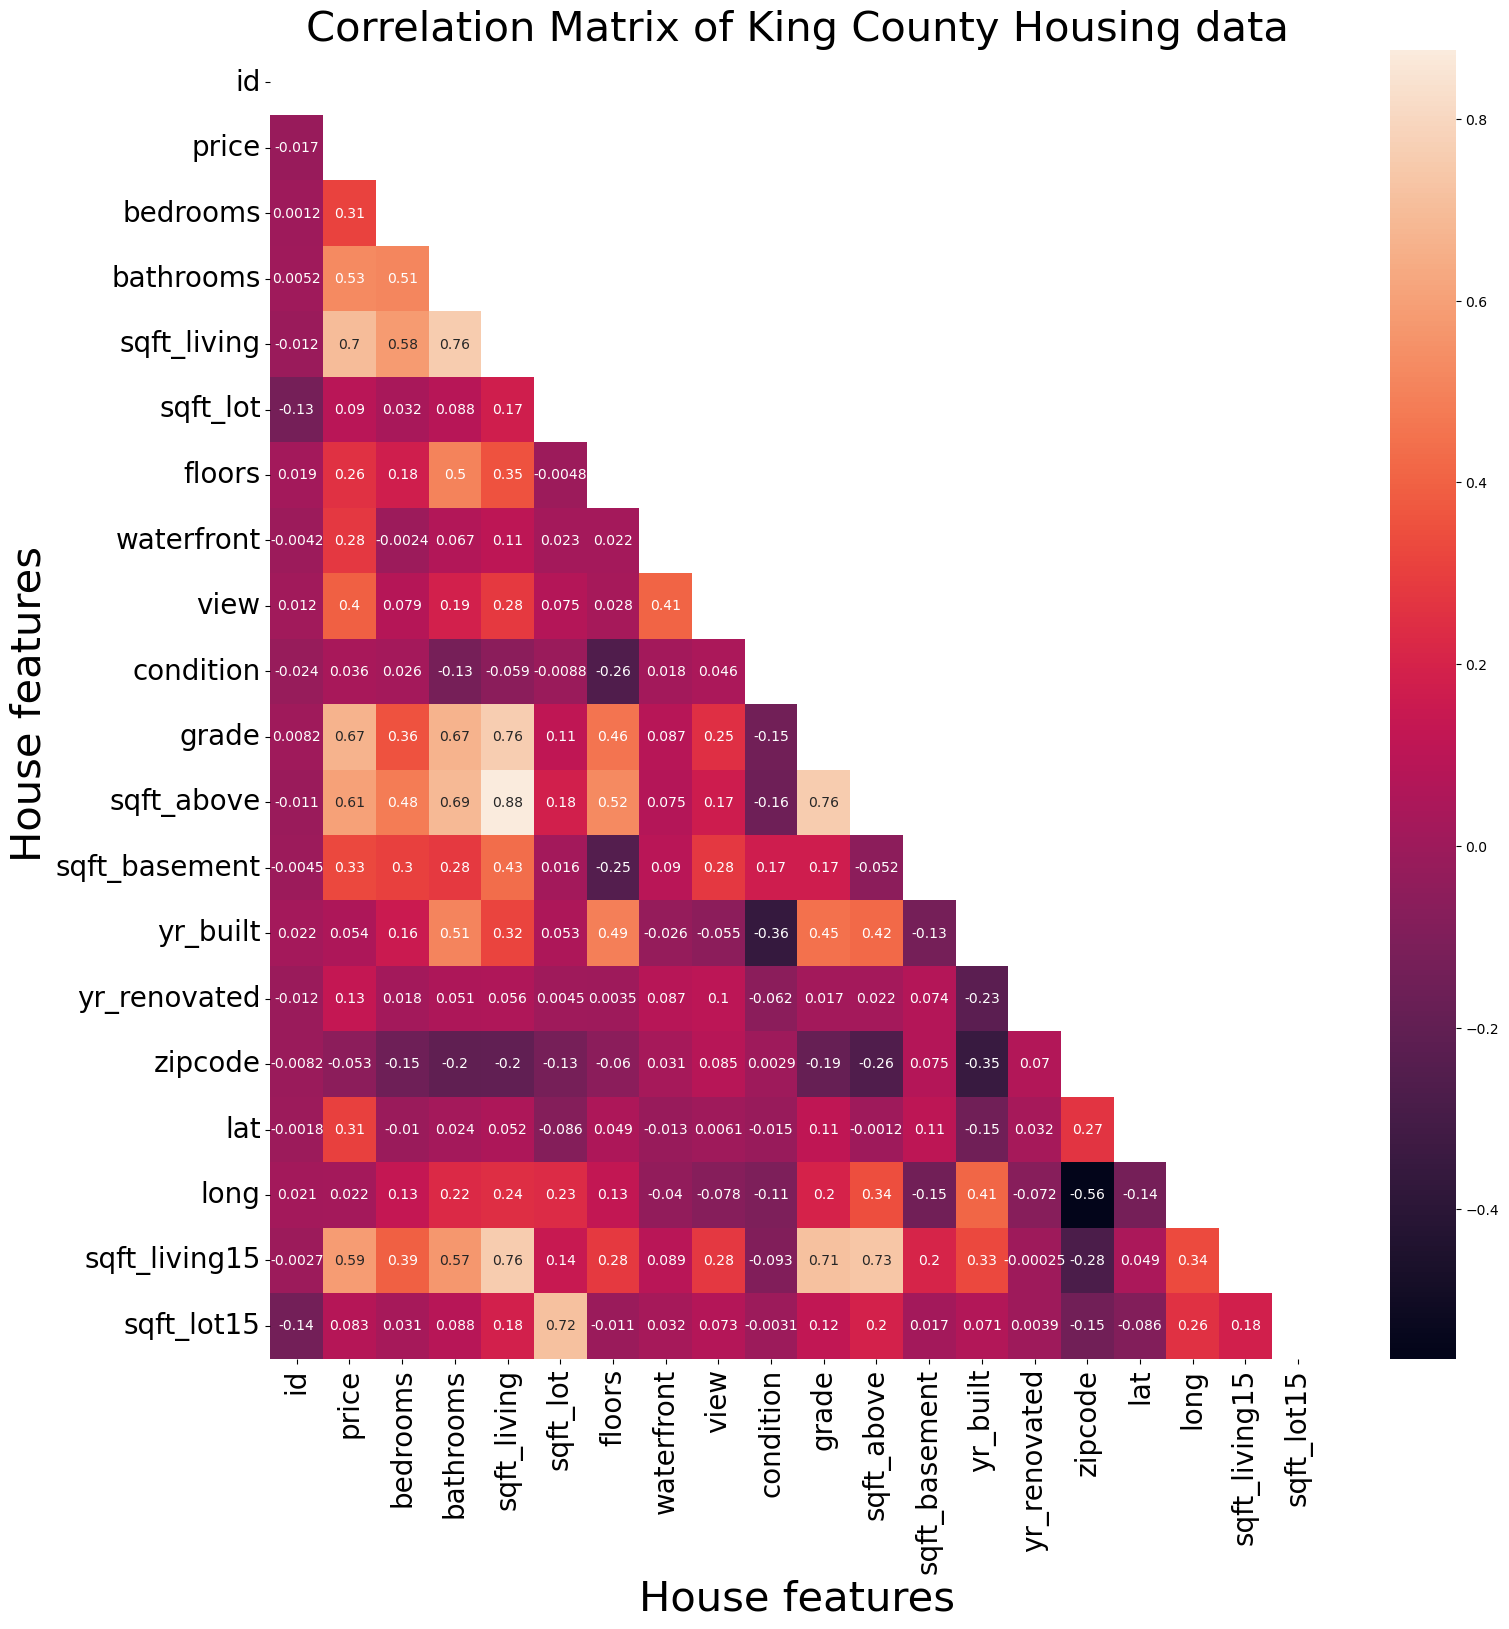

In [10]:
# correlation matrix with duplicated removed
corrMatrix = df.corr()
matrix = np.triu(corrMatrix)

# plot correlation matrix in heat map with seaborn
fig, ax = plt.subplots(figsize=(17,17)) 
sns.heatmap(corrMatrix, annot=True, mask=matrix)

# label plot
plt.title('Correlation Matrix of King County Housing data', size=30)
plt.xlabel('House features', size=30)
plt.ylabel('House features', size=30)
plt.xticks(size=20)
plt.yticks(size=20);

## Modeling

Create a regression model that uses ordinary least squares to asses the predicitve power of the mean square footage of a zipcode with the mean sales price of its houses.

In [11]:
# group mean price and square footage by zipcode
zipcode_df = df[['zipcode', 'price','sqft_living']]
zipcode_df = zipcode_df.groupby(['zipcode']).mean().sort_values('price', ascending=False).round(2)

In [13]:
# fit model and print summary statistics  
model_price_sqft = ols(formula='price ~ sqft_living', data=zipcode_df).fit() 
model_price_sqft.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     95.97
Date:                Sun, 24 Sep 2023   Prob (F-statistic):           1.26e-14
Time:                        14:54:07   Log-Likelihood:                -951.38
No. Observations:                  70   AIC:                             1907.
Df Residuals:                      68   BIC:                             1911.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5.561e+05   1.16e+05     -4.777      0.000   -7.88e+05   -3.24e+05
sqft_living   532.2587     54.332      9.796      0.000     423.841     640.676
==============================================================================
Omnibus:                       11.344   Durbin-Watson:                   1.114
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.497
Skew:                           0.908   Prob(JB):                      0.00319
Kurtosis:                       3.801   Cond. No.                     1.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Results analysis:
When grouped by Zip Code, the correlation between average sales price and average square footage is 0.77. This is .07 higher than when not grouped. This is why, when put into the regression model, average square footage explains 59% of the varinace in sales. 

In [14]:
print(f'''
Correlation before grouped: {df.price.corr(df.sqft_living):.2f}
Correlation grouped by zip code: {zipcode_df.price.corr(zipcode_df.sqft_living):.2f}
R-squared of model: {model_price_sqft.rsquared:.0%}
''')


Correlation before grouped: 0.70
Correlation grouped by zip code: 0.77
R-squared of model: 59%



Testing normality of the residual errors for the above model. 

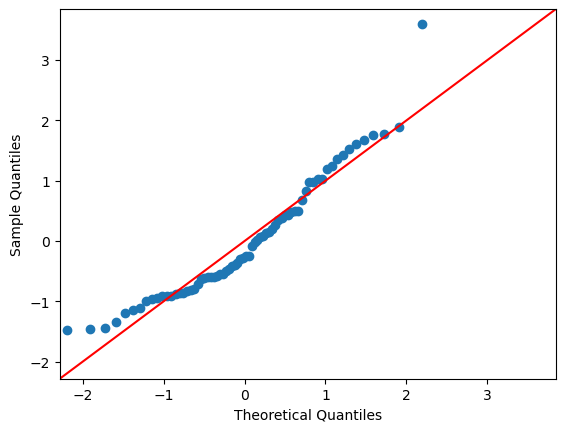

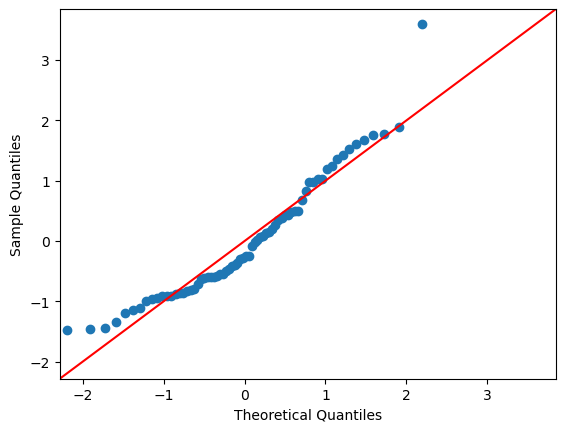

In [15]:
# list residual errors than plot
residuals = model_price_sqft.resid
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

Testing the above model for variance and heteroscedasticity to ensure the assumptions of ordinary least squares are not violated. 

eval_env: 1


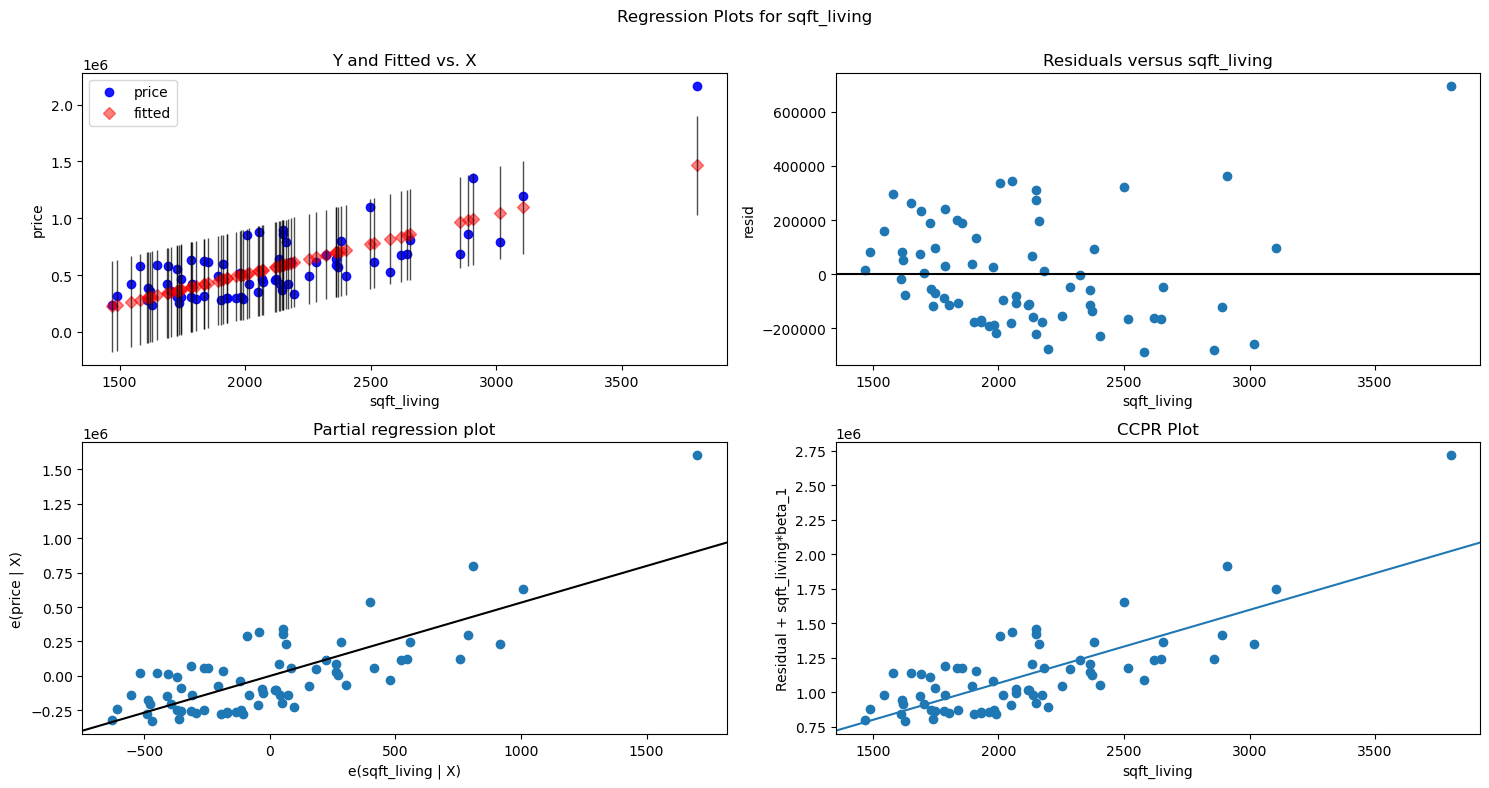

In [16]:
# plot analysis of model results 
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model_price_sqft, "sqft_living", fig=fig)
plt.show()

In [17]:
formula = 'price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + view + condition + grade + sqft_above + sqft_basement + yr_built + yr_renovated'
#Included everything about the house, not the date or the neighborhood.
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     2444.
Date:                Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:03:09   Log-Likelihood:            -2.1162e+05
No. Observations:               15429   AIC:                         4.233e+05
Df Residuals:                   15416   BIC:                         4.234e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.361e+06   1.66e+05     38.393      0.000    6.04e+06    6.69e+06
bedrooms      -4.026e+04   2405.811    -16.735      0.000    -4.5e+04   -3.55e+04
bathrooms      4.871e+04   4194.097     11.615      0.000    4.05e+04    5.69e+04
sqft_living     117.9532      2.728     43.231      0.000     112.605     123.301
sqft_lot         -0.2691      0.043     -6.230      0.000      -0.354      -0.184
floors         2.317e+04   4495.484      5.154      0.000    1.44e+04     3.2e+04
waterfront     6.116e+05   2.24e+04     27.264      0.000    5.68e+05    6.56e+05
view           4.572e+04   2726.508     16.768      0.000    4.04e+04    5.11e+04
condition      1.806e+04   2989.985      6.040      0.000    1.22e+04    2.39e+04
grade          1.209e+05   2607.117     46.377      0.000    1.16e+05    1.26e+05
sqft_above       61.6652      2.619     23.544      0.000      56.531      66.799
sqft_basement    56.2881      3.317     16.968      0.000      49.786      62.791
yr_built      -3649.8002     84.875    -43.002      0.000   -3816.165   -3483.435
yr_renovated     10.0322      4.744      2.115      0.034       0.733      19.331
==============================================================================
Omnibus:                    11774.273   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           893408.218
Skew:                           3.062   Prob(JB):                         0.00
Kurtosis:                      39.772   Cond. No.                     1.46e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.45e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [18]:
formula = 'price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + view + condition + grade + sqft_above + sqft_basement'
#dropped a few categories, no relevant change in the data, still violates assumptions.
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     2918.
Date:                Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:03:50   Log-Likelihood:            -2.5827e+05
No. Observations:               18749   AIC:                         5.166e+05
Df Residuals:                   18738   BIC:                         5.166e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -6.991e+05   1.89e+04    -36.985      0.000   -7.36e+05   -6.62e+05
bedrooms      -3.595e+04   2339.163    -15.369      0.000   -4.05e+04   -3.14e+04
bathrooms     -1.553e+04   3792.901     -4.096      0.000    -2.3e+04   -8099.889
sqft_living     138.3327      2.592     53.371      0.000     133.252     143.413
sqft_lot         -0.3529      0.043     -8.267      0.000      -0.437      -0.269
floors        -2659.0747   4278.517     -0.621      0.534    -1.1e+04    5727.207
waterfront      6.04e+05   2.15e+04     28.055      0.000    5.62e+05    6.46e+05
view            6.03e+04   2592.630     23.257      0.000    5.52e+04    6.54e+04
condition      5.475e+04   2739.901     19.981      0.000    4.94e+04    6.01e+04
grade          1.028e+05   2456.150     41.843      0.000     9.8e+04    1.08e+05
sqft_above       55.5656      2.514     22.102      0.000      50.638      60.493
sqft_basement    82.7671      3.169     26.120      0.000      76.556      88.978
==============================================================================
Omnibus:                    13725.867   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           842730.975
Skew:                           2.935   Prob(JB):                         0.00
Kurtosis:                      35.315   Cond. No.                     2.03e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.67e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [19]:
formula4 = 'price ~ sqft_living'
#testing individuals to see how they correlate, and which assumptions they violate individually
#sqft_living, while a key factor and statistically significant to price, is not a normal distribution, 
#and there is clear collinearity issues.
liv_mod = ols(formula=formula4, data=df).fit()
liv_mod_sum = liv_mod.summary()

liv_mod_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:03:56   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
formula1 = 'price ~ bedrooms'
#Bedrooms is not a normal distribution, BUT it does not have collinearity issues on the surface level, due to the 
#coef vs std err AND Cond. No. being between 10-30. Statistically significant according to the model, but only accounts for
#(almost) 10% of the data
bed_mod = ols(formula=formula1, data=df).fit()
bed_mod_sum = bed_mod.summary()

bed_mod_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     2276.
Date:                Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:04:06   Log-Likelihood:            -3.0631e+05
No. Observations:               21597   AIC:                         6.126e+05
Df Residuals:                   21595   BIC:                         6.126e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.272e+05   8979.293     14.166      0.000     1.1e+05    1.45e+05
bedrooms    1.225e+05   2566.930     47.709      0.000    1.17e+05    1.27e+05
==============================================================================
Omnibus:                    18831.341   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1195104.832
Skew:                           3.900   Prob(JB):                         0.00
Kurtosis:                      38.598   Cond. No.                         14.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
formula3 = 'price ~ bedrooms+bathrooms+sqft_living+sqft_lot+floors+waterfront+view+condition+grade+sqft_above+sqft_basement'
#It seems if we are just going to accept the fact that our LINEAR model is going to have issues with assumptions.
#It would be best to include more data so we atleast have a higher R-Squared and can account for more variance within our model
room_mod = ols(formula=formula3, data=df).fit()
room_mod_sum = room_mod.summary()

room_mod_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     2918.
Date:                Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:04:12   Log-Likelihood:            -2.5827e+05
No. Observations:               18749   AIC:                         5.166e+05
Df Residuals:                   18738   BIC:                         5.166e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -6.991e+05   1.89e+04    -36.985      0.000   -7.36e+05   -6.62e+05
bedrooms      -3.595e+04   2339.163    -15.369      0.000   -4.05e+04   -3.14e+04
bathrooms     -1.553e+04   3792.901     -4.096      0.000    -2.3e+04   -8099.889
sqft_living     138.3327      2.592     53.371      0.000     133.252     143.413
sqft_lot         -0.3529      0.043     -8.267      0.000      -0.437      -0.269
floors        -2659.0747   4278.517     -0.621      0.534    -1.1e+04    5727.207
waterfront      6.04e+05   2.15e+04     28.055      0.000    5.62e+05    6.46e+05
view            6.03e+04   2592.630     23.257      0.000    5.52e+04    6.54e+04
condition      5.475e+04   2739.901     19.981      0.000    4.94e+04    6.01e+04
grade          1.028e+05   2456.150     41.843      0.000     9.8e+04    1.08e+05
sqft_above       55.5656      2.514     22.102      0.000      50.638      60.493
sqft_basement    82.7671      3.169     26.120      0.000      76.556      88.978
==============================================================================
Omnibus:                    13725.867   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           842730.975
Skew:                           2.935   Prob(JB):                         0.00
Kurtosis:                      35.315   Cond. No.                     2.03e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.67e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [22]:
formula2 = 'price ~ bathrooms'
#Like bedrooms, not a normal distribution, but it doesnt seem to have collinearity AND its statistically significant while holding
#a solid R-Squared score.
bath_mod = ols(formula=formula2, data=df).fit()
bath_mod_sum = bath_mod.summary()

bath_mod_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     8256.
Date:                Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:04:17   Log-Likelihood:            -3.0389e+05
No. Observations:               21597   AIC:                         6.078e+05
Df Residuals:                   21595   BIC:                         6.078e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8712.6518   6224.769      1.400      0.162   -3488.356    2.09e+04
bathrooms   2.512e+05   2765.054     90.863      0.000    2.46e+05    2.57e+05
==============================================================================
Omnibus:                    17251.570   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           882735.889
Skew:                           3.452   Prob(JB):                         0.00
Kurtosis:                      33.550   Cond. No.                         7.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After looking over some of the base models and how some of the independent variable correlated to price, it is time to build visualizations

In [23]:
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model', 'Final Model']
models_num = np.array([0.095, 0.277, 0.493, 0.609, 0.609, 0.655])

### Visualizations

### Plotting the regression of the model.

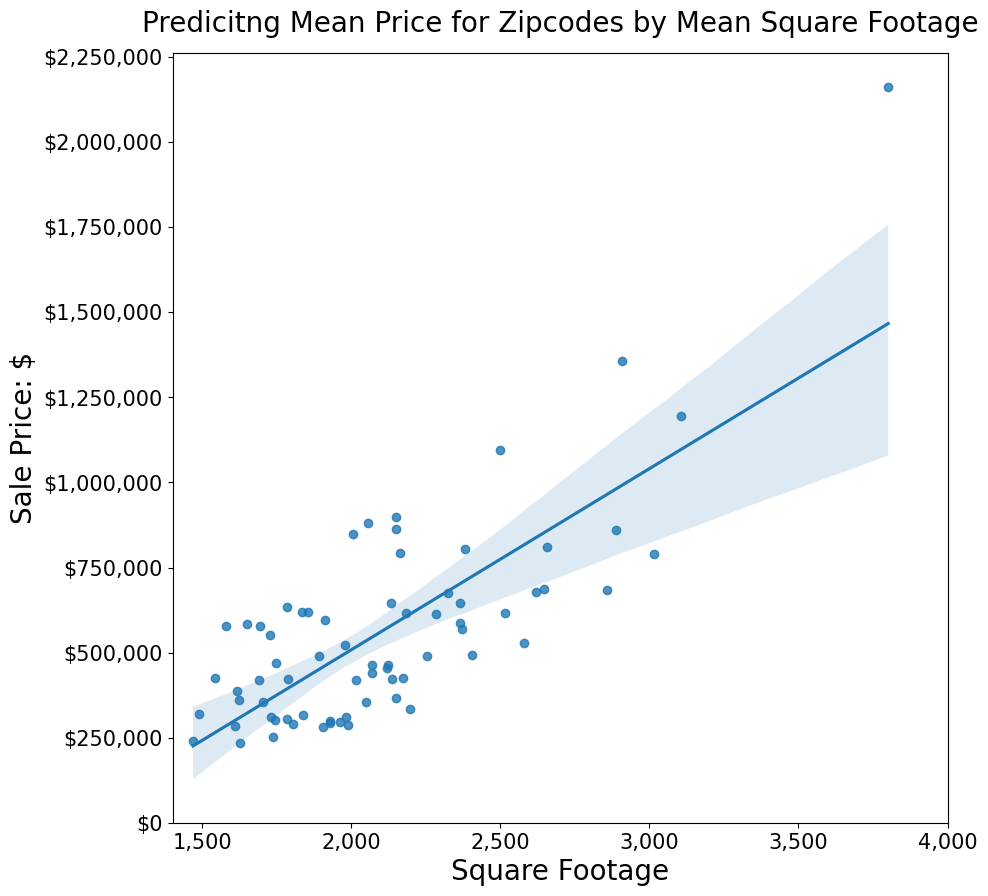

In [24]:
# plot
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.regplot(x=zipcode_df.sqft_living.values, y=zipcode_df.price.values)

# title
plt.title('Predicitng Mean Price for Zipcodes by Mean Square Footage', size=20, pad=15)

# x axis
x_ticks = [1500, 2000, 2500, 3000, 3500, 4000]
x_labels = ['1,500', '2,000', '2,500', '3,000', '3,500', '4,000']
plt.xlabel('Square Footage', size=20)
plt.xticks(x_ticks, x_labels, size=15)
ax.set_xlim(1400,4000)

# y axis 
plt.ylabel('Sale Price: $', size=20)
y_ticks = [0, 250000, 500000, 750000, 1000000, 1250000, 1500000, 1750000, 2000000, 2250000]
y_labels = ['$0', '$250,000', '$500,000', '$750,000', '$1,000,000', '$1,250,000', '$1,500,000', 
          '$1,750,000', '$2,000,000', '$2,250,000']
plt.yticks(y_ticks, y_labels, size=15);

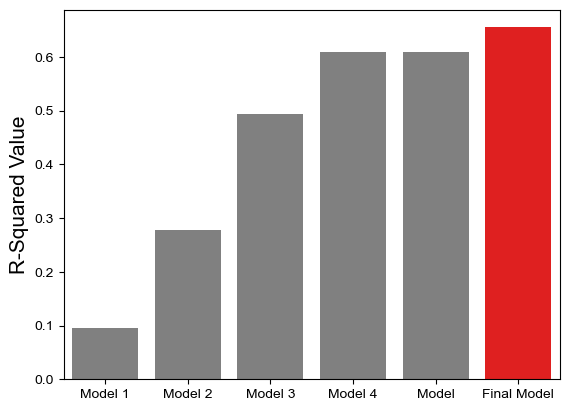

In [25]:
clrs = ['grey' if (x < max(models_num)) else 'red' for x in models_num ]
sns.barplot(x=models, y=models_num, palette=clrs)
plt.ylabel('R-Squared Value', size=15)
sns.set_style('dark')


### Creating Map

Make DataFrame for map

In [26]:
# make searies for residual errors
zipcode_erros = model_price_sqft.resid.round(2).rename('residual_error')

# attach erros to zipcode DataFrame 
map_df = zipcode_df.join(zipcode_erros, on=zipcode_erros.index).reset_index()
map_df.zipcode = map_df.zipcode.astype('str')

### Insight: Features are related to the actual house and the area in which the house is located. Three models will be built for price: Inferential, Predictive, and a model based upon area.

In [36]:
df.fillna(0, inplace=True)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12-09-2014,538000,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,12-09-2014,604000,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


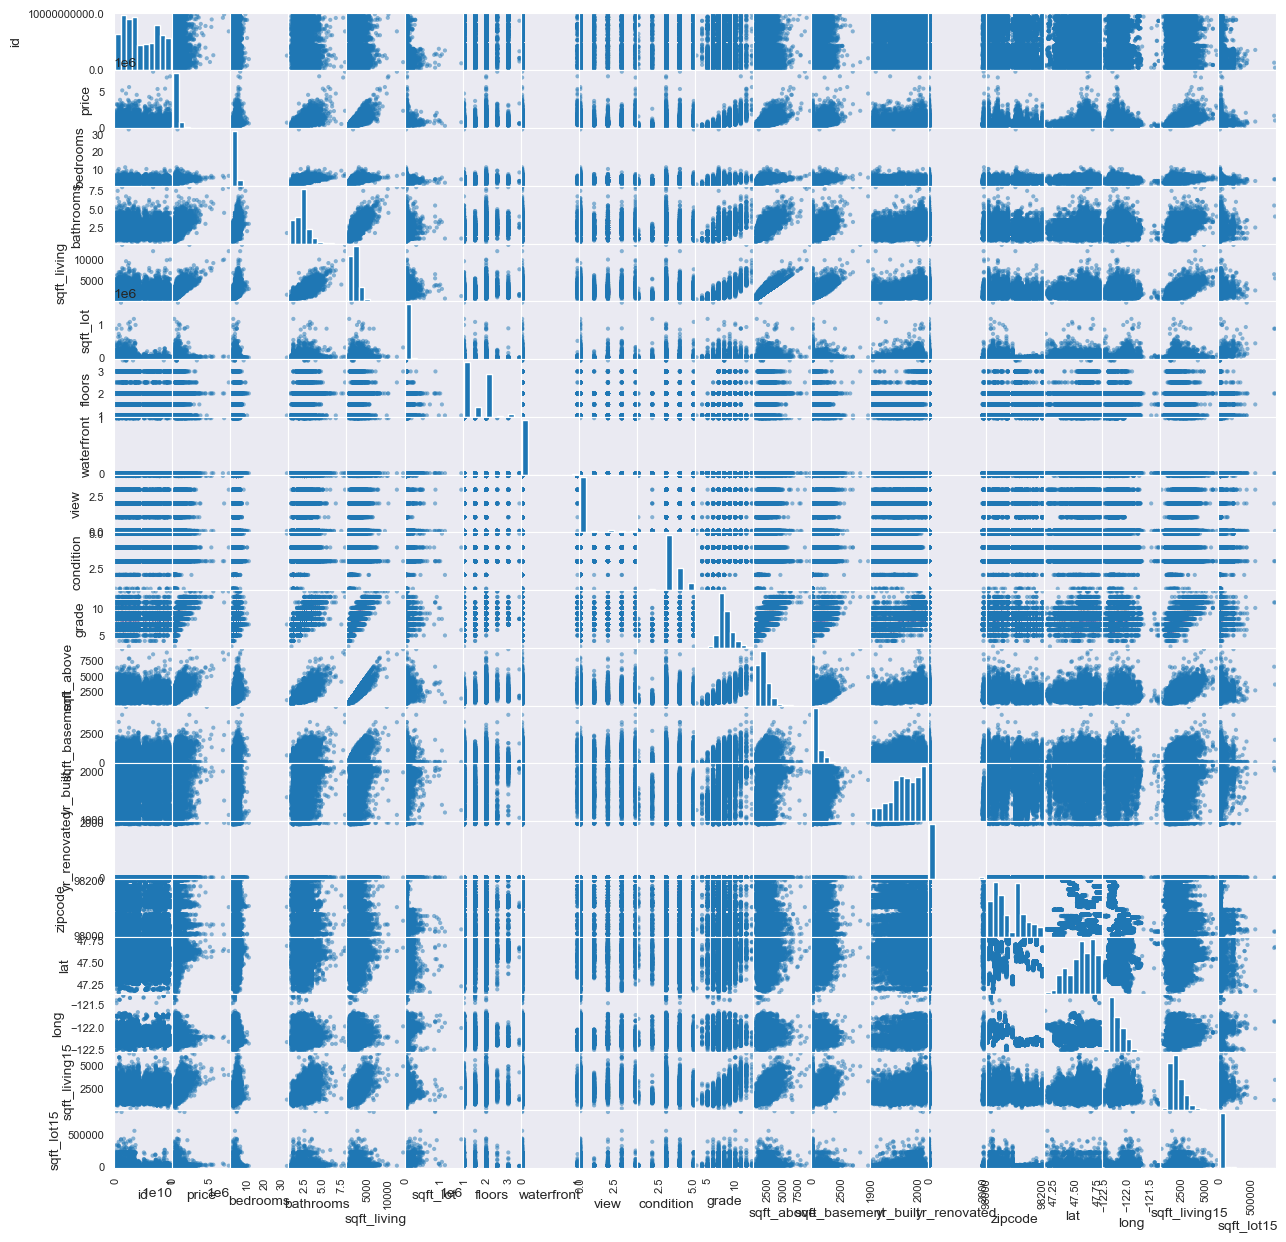

In [37]:
pd.plotting.scatter_matrix(df, figsize=[15, 15]);

plt.show()

In [38]:
df.corr()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8732\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.003599,0.011772,-0.023803,0.008188,-0.010799,-0.004359,0.021617,-0.010612,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.264306,0.393497,0.036056,0.667951,0.605368,0.321108,0.053953,0.117855,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002127,0.078354,0.026496,0.356563,0.479386,0.297229,0.155670,0.017900,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.063629,0.186016,-0.126479,0.665838,0.686668,0.278485,0.507173,0.047177,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.104637,0.281715,-0.059445,0.762779,0.876448,0.428660,0.318152,0.051060,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.021459,0.075054,-0.008830,0.114731,0.184139,0.015031,0.052946,0.004979,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.020797,0.028414,-0.264075,0.458794,0.523989,-0.241866,0.489193,0.003793,-0.059541,0.049239,0.125943,0.280102,-0.010722
waterfront,-0.003599,0.264306,-0.002127,0.063629,0.104637,0.021459,0.020797,1.000000,0.380543,0.016648,0.082818,0.071778,0.083050,-0.024487,0.073939,0.028923,-0.012157,-0.037628,0.083823,0.030658
view,0.011772,0.393497,0.078354,0.186016,0.281715,0.075054,0.028414,0.380543,1.000000,0.045622,0.249082,0.166017,0.270629,-0.054452,0.090339,0.085059,0.006321,-0.077702,0.278928,0.073083
condition,-0.023803,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.016648,0.045622,1.000000,-0.146896,-0.158904,0.168482,-0.361592,-0.055808,0.002888,-0.015102,-0.105877,-0.093072,-0.003126


In [39]:
abs(df.corr()) > 0.75

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8732\443343859.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  abs(df.corr()) > 0.75


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


### Insight: sqft_living is also highly correlated with bathrooms, grade, sqft_above, and sqft_living15. These features will be dropped from the predictive model due to collinearity.

## MODEL CREATION (SKLEARN, predictive)

In [81]:
y = df[['price']]
X = df.drop(['id', 'price', 'date', 'bathrooms', 'grade', 'sqft_above', 'sqft_living15'], axis=1)

In [83]:
print(X)
print(y)

       bedrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  \
0             3         1180      5650     1.0         0.0   0.0          3   
1             3         2570      7242     2.0         0.0   0.0          3   
2             2          770     10000     1.0         0.0   0.0          3   
3             4         1960      5000     1.0         0.0   0.0          5   
4             3         1680      8080     1.0         0.0   0.0          3   
...         ...          ...       ...     ...         ...   ...        ...   
21592         3         1530      1131     3.0         0.0   0.0          3   
21593         4         2310      5813     2.0         0.0   0.0          3   
21594         2         1020      1350     2.0         0.0   0.0          3   
21595         3         1600      2388     2.0         0.0   0.0          3   
21596         2         1020      1076     2.0         0.0   0.0          3   

       sqft_basement  yr_built  yr_renovated  zipco

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=42)

In [84]:
#create dummy regressor as baseline
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
dy_pred = dummy.predict(X_train)
dy_pred_test = dummy.predict(X_test)

In [85]:
dummy.score(X_train, y_train)

0.0

In [86]:
#linear regression model with no feature adjustments
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.6624869705567369

In [87]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_train)
y_pred_test = linreg.predict(X_test)

In [88]:
linreg.score(X_test, y_test)

0.6611935531140272

In [89]:
r2_score(y_test, y_pred_test)

0.6611935531140272

In [90]:
RMSE_train = mean_squared_error(y_train, y_pred, squared=False)
RMSE_test = mean_squared_error(y_test, y_pred_test, squared=False)
print('RMSE for test set is: ', RMSE_test)
print("RMSE for training set is: ", RMSE_train)

RMSE for test set is:  210043.126980939
RMSE for training set is:  214324.32495325195


## QQ plot for sklearn model

### INSIGHT: To get a QQ plot for sklearn, we must do y_train - y_pred to calculate residuals. 

In [49]:
y_pred.shape

(17277, 1)

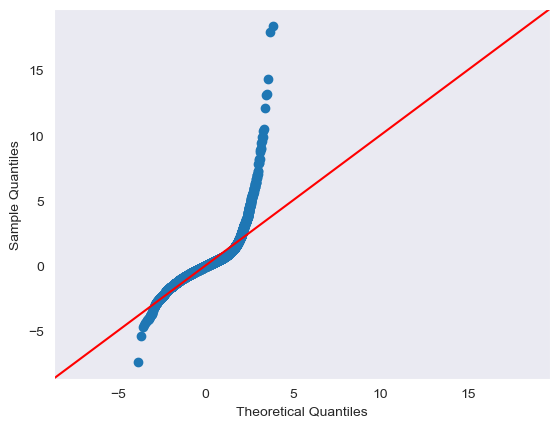

In [50]:
#qq plot of residuals
resid1 = y_train - y_pred

fig = sm.graphics.qqplot(resid1['price'], dist=stats.norm, line='45', fit=True)

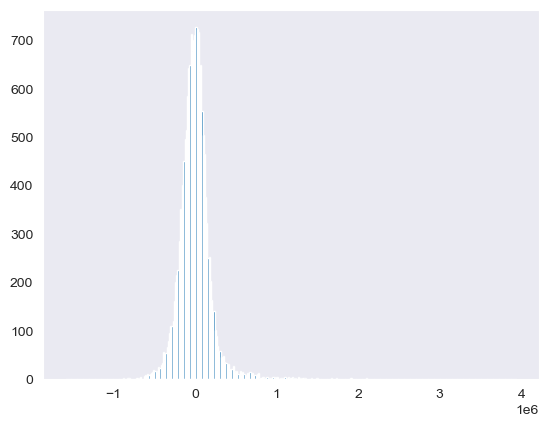

In [51]:
#hist plot of residuals
plt.hist(resid1['price'], bins='auto')
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8732\1127133118.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(resid1['price']);


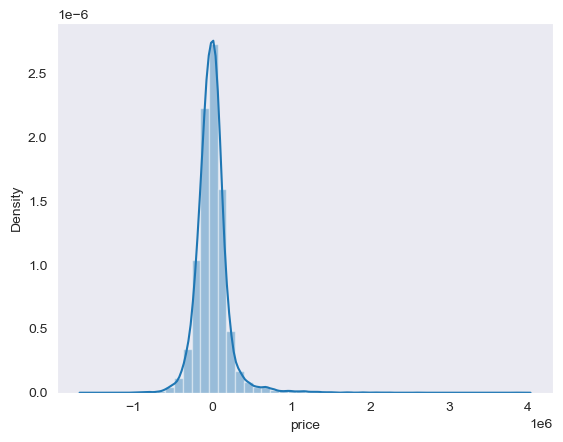

In [52]:
sns.distplot(resid1['price']);

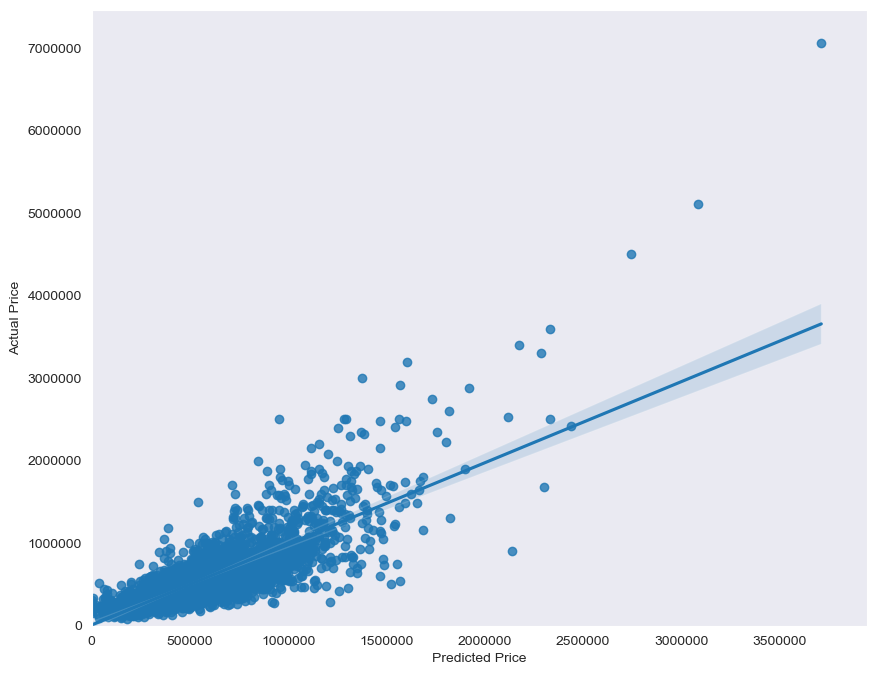

In [53]:
#visualizing predicted price vs actual price
fig, ax = plt.subplots(figsize=(10, 8))
sns.regplot(x=y_pred_test, y=y_test, data=df)
ax.set_xlabel("Predicted Price")
ax.set_ylabel("Actual Price")
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
ax.ticklabel_format(useOffset=False, style='plain')
plt.show();

In [54]:
#examining skew and kurtosis of sklearn model

from scipy.stats import kurtosis, skew
print(skew(resid1))
print(kurtosis(resid1))

[2.93596039]
[31.15108497]


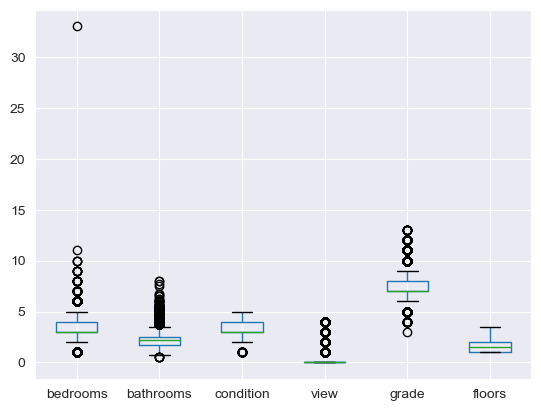

In [55]:
#boxplot of various features to examine outliers
df.boxplot(column = ['bedrooms', 'bathrooms', 'condition', 'view', 'grade', 'floors']);

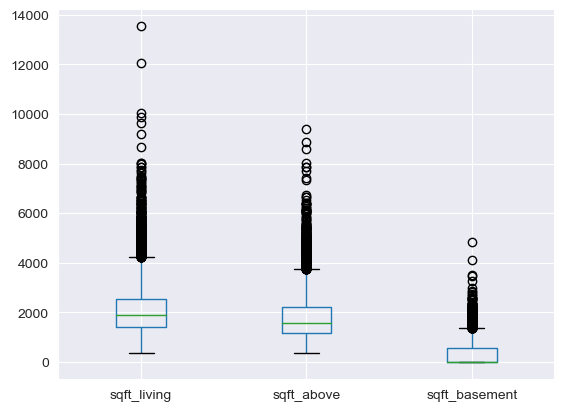

In [56]:
#sqft outliers
df.boxplot(column=['sqft_living', 'sqft_above', 'sqft_basement']);

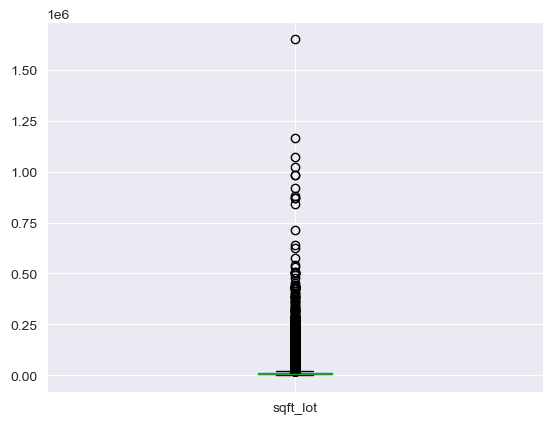

In [57]:
df.boxplot(column='sqft_lot');

### Insight: The model is severely affected by outliers. We will remove the outliers in the data and re-test the model.

In [58]:
#dropping outliers from key features related to the house itself

total_drop = []
for col in ['sqft_living', 'bedrooms', 'sqft_lot', 'sqft_above', 'bathrooms', 'floors']:
    to_drop = np.where(np.abs(stats.zscore(df[col])) > 1.96)[0].tolist()
    total_drop.extend(to_drop)
    
drop_idx = list(set(total_drop))


df2 = df.drop(to_drop)
df2.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12-09-2014,538000,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,12-09-2014,604000,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [59]:
#including all features for model improvement

y1 = df2[['price']]
X1 = df2.drop(['id', 'price', 'date'], axis=1)


In [60]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2,
                                                   random_state=42)

In [61]:
linreg = LinearRegression()
linreg.fit(X1_train, y1_train)
y1_pred = linreg.predict(X1_train)
y1_pred_test = linreg.predict(X1_test)

In [62]:
r2_score(y1_test, y1_pred_test)

0.6902065365422609

In [63]:
#RMSE of outlier free model

RMSE_train = mean_squared_error(y1_train, y1_pred, squared=False)
RMSE_test = mean_squared_error(y1_test, y1_pred_test, squared=False)
print('RMSE for test set is: ', RMSE_test)
print("RMSE for training set is: ", RMSE_train)

RMSE for test set is:  195547.4583437814
RMSE for training set is:  203314.49575459972


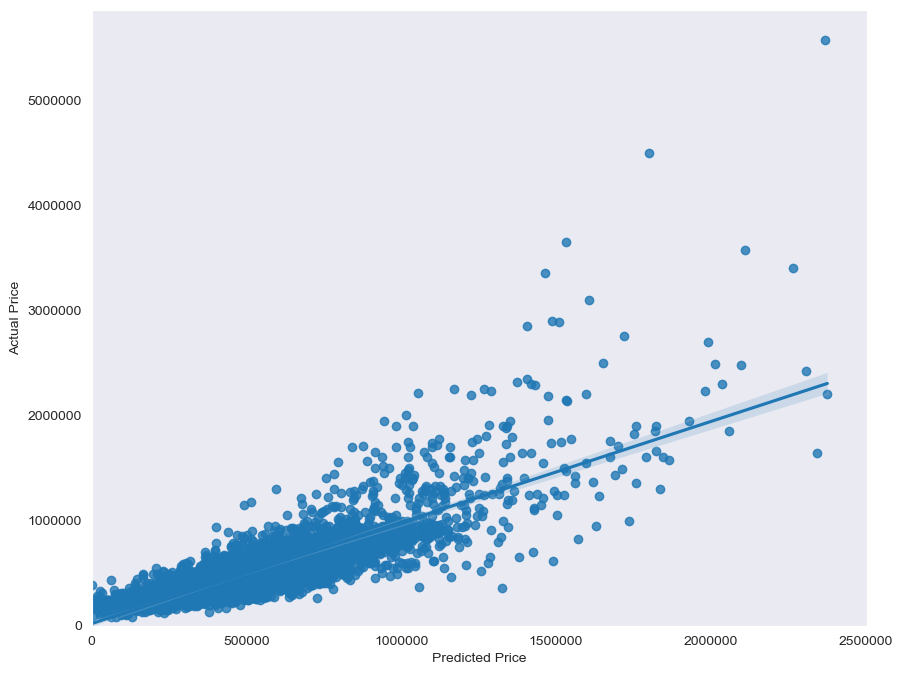

In [64]:
#actual price vs predicted price
fig, ax = plt.subplots(figsize=(10, 8))
sns.regplot(x=y1_pred_test, y=y1_test, data=df)
ax.set_xlabel("Predicted Price")
ax.set_ylabel("Actual Price")
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
ax.ticklabel_format(useOffset=False, style='plain')

plt.show();

### Insight: removing outliers improved the RMSE overall. Will scaling the features improve the model?

In [65]:
#standard scaler
scaler = StandardScaler()

In [67]:
scaler.fit(X1_train)

StandardScaler()

In [68]:
scaler.transform(X1_train)

array([[-1.48324435, -0.78917715, -1.16811018, ..., -0.97404424,
        -1.42663505, -0.33544689],
       [-0.4121506 , -1.4367002 , -1.21166034, ..., -1.17286864,
        -1.01926358, -0.19794044],
       [-0.4121506 , -0.46541563,  0.36703314, ..., -1.28648258,
         0.20285084, -0.17633017],
       ...,
       [ 0.65894316,  0.50586894,  1.36868693, ...,  0.2047004 ,
         1.06124072, -0.25707265],
       [-0.4121506 ,  0.18210742,  1.05294824, ...,  0.73726575,
         1.5413571 , -0.05381029],
       [-1.48324435, -1.4367002 , -1.34231084, ..., -1.10185993,
        -0.62644109, -0.29119024]])

In [69]:
#create X_train_scaled to store different models

regression = LinearRegression()
regression.fit(scaler.transform(X1_train), y1_train)
regression.score(scaler.transform(X1_test), y1_test)

0.6902065365422552

In [70]:
X_scale_train = scaler.transform(X1_train)
X_scale_test = scaler.transform(X1_test)


In [71]:
y_scale_pred = regression.predict(X_scale_train)
y_scale_testpred = regression.predict(X_scale_test)
y_scale_pred.shape

(16783, 1)

In [72]:
print(r2_score(y1_test, y_scale_testpred))

0.6902065365422552


In [73]:
RMSE_train = mean_squared_error(y1_train, y_scale_pred, squared=False)
RMSE_test = mean_squared_error(y1_test, y_scale_testpred, squared=False)
print('RMSE for test set is: ', RMSE_test)
print("RMSE for training set is: ", RMSE_train)

RMSE for test set is:  195547.45834378322
RMSE for training set is:  203314.4957545997


### Insight: The model did not improve. Attempting MinMaxScaler method

In [74]:
#minmax scaler attempt
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
mmscaler.fit(X_train)

MinMaxScaler()

In [75]:
linreg2 = LinearRegression()
linreg2.fit(mmscaler.transform(X_train), y_train)
linreg2.score(mmscaler.transform(X_test), y_test)

0.6611935531140409

In [76]:
X_mmscale_train = mmscaler.transform(X_train)
X_mmscale_test = mmscaler.transform(X_test)

In [77]:
y_mmscale_pred = linreg2.predict(X_mmscale_train)
y_mmscale_testpred = linreg2.predict(X_mmscale_test)

In [78]:
r2_score(y_test, y_mmscale_testpred)

0.6611935531140409

In [79]:
RMSE_train = mean_squared_error(y_train, y_mmscale_pred, squared=False)
RMSE_test = mean_squared_error(y_test, y_mmscale_testpred, squared=False)
print('RMSE for test set is: ', RMSE_test)
print("RMSE for training set is: ", RMSE_train)

RMSE for test set is:  210043.12698093476
RMSE for training set is:  214324.32495325195


### Conclusions

Strongest feature, square footage,  performs best in suburbs outside of Seattle.

Despite transformations, standard and minmax scaling, and elimination of outliers, the models still all perform similarly, with varying RMSE between them. This indicates that a predictive linear regression model might not be the most effective model at predicting prices with the given features. The highest performing model is the one free of outliers before scaling and transformation.